# Event building
これまでのデータは、1行に検出器1ヒットのデータが書かれていた。<br>
検出器間の相関を見るには、タイムスタンプが一定時間以内のヒットを同一イベントとしてまとめる必要がある。<br>
このノートでは、クローバー型Ge検出器を例としてイベントビルドとAdd back、γ-γの相関を作る。

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()
df = spark.read.parquet("./data/clover_caldata.parquet").select("ch","adc_cal","ts")

df.show(10)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/09 17:24:40 WARN Utils: Your hostname, TABLET-S9I8ER9S, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/09 17:24:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/09 17:24:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

+---+-------------------+-------------+
| ch|            adc_cal|           ts|
+---+-------------------+-------------+
|  4| 1173.5435834050113|7296321907778|
|  2| 227.55610453923023|7296321978243|
|  1| 448.58882035985226|7296321997358|
|  0| 0.2826225528521701|7296322069363|
|  4|  1333.927759363862|7296322214400|
|  1| 191.52228016285895|7296322271040|
|  4|  387.5998010516098|7296322391382|
|  0|0.28619243752816936|7296322439661|
|  7|  70.49284476238016|7296322447462|
|  2| 1117.0257870446542|7296322574024|
+---+-------------------+-------------+
only showing top 10 rows


## 検出器idを付ける
クローバー検出器は、一台4チャンネルの読み出しがある。<br>
ch0-3がdet0, ch4-8がdet1となるように"det"列を定義する。<br>
- floor(): 整数に切り捨てる関数

In [23]:
df = df.withColumn("det", F.expr("floor(ch/4)"))
df.show(10)

+---+-------------------+-------------+---+
| ch|            adc_cal|           ts|det|
+---+-------------------+-------------+---+
|  4| 1173.5435834050113|7296321907778|  1|
|  2| 227.55610453923023|7296321978243|  0|
|  1| 448.58882035985226|7296321997358|  0|
|  0| 0.2826225528521701|7296322069363|  0|
|  4|  1333.927759363862|7296322214400|  1|
|  1| 191.52228016285895|7296322271040|  0|
|  4|  387.5998010516098|7296322391382|  1|
|  0|0.28619243752816936|7296322439661|  0|
|  7|  70.49284476238016|7296322447462|  1|
|  2| 1117.0257870446542|7296322574024|  0|
+---+-------------------+-------------+---+
only showing top 10 rows


## タイムスタンプが500ns以上離れているヒット毎にグループ番号を付ける
### Window関数
SparkSQLにはWindow関数といって、データフレーム上の設定した範囲(window)毎に集計を行う関数が用意されている。<br>
avg、max、min、rank、lagなどがある。<br>
partitionBy()でWindowの範囲、orderBy()で並び順を定義する。<br>
例えば、
```
w = Window.partitionBy("A")
```
のようにWindowを定義し、
```
avg("C").over(w)
```
とすると、A毎のCの平均値を作ってくれる。

ここでは、検出器毎にタイムスタンプ順に並び替えたwindowを定義したいので、
```
w = Window.partitionBy("det").orderBy("ts")
```
とする。

次に、lag()関数を使って"ts_prev"という列を定義する。
```
.withColumn("ts_prev", F.lag("ts").over(w))
```
lag()は行を一つずらした列を返す関数なので、"ts_prev"は一つ前のヒットのタイムスタンプになる。<br>
その後、前のヒットとの時間を現す、"gap"という列を定義する。
```
.withColumn("gap", F.expr("CASE WHEN ts_prev IS NULL THEN 0 ELSE ts - ts_prev END"))
```
lag()を使うと最初の行がNullになるので0に置き換えている。<br>
sum()関数を使い、"gap"がTIME_WINDOW以上であれば1増やすという方法で"goup_id"を定義する。

In [25]:
from pyspark.sql import Window

w = Window.partitionBy("det").orderBy("ts")

TIME_WINDOW = 500
df_group = (
    df
    .withColumn("ts_prev", F.lag("ts").over(w))
    .withColumn("gap", F.expr("CASE WHEN ts_prev IS NULL THEN 0 ELSE ts - ts_prev END"))
    .withColumn("group_id", F.sum(F.expr(f"CASE WHEN gap > {TIME_WINDOW} THEN 1 ELSE 0 END")).over(w))
)

df_group.show(10)

+---+-------------------+-------------+---+-------------+------+--------+
| ch|            adc_cal|           ts|det|      ts_prev|   gap|group_id|
+---+-------------------+-------------+---+-------------+------+--------+
|  2| 227.55610453923023|7296321978243|  0|         NULL|     0|       0|
|  1| 448.58882035985226|7296321997358|  0|7296321978243| 19115|       1|
|  0| 0.2826225528521701|7296322069363|  0|7296321997358| 72005|       2|
|  1| 191.52228016285895|7296322271040|  0|7296322069363|201677|       3|
|  0|0.28619243752816936|7296322439661|  0|7296322271040|168621|       4|
|  2| 1117.0257870446542|7296322574024|  0|7296322439661|134363|       5|
|  1|  1171.619417638148|7296322620796|  0|7296322574024| 46772|       6|
|  3| 1174.6657429896075|7296322690194|  0|7296322620796| 69398|       7|
|  1|  995.0230880585855|7296322760004|  0|7296322690194| 69810|       8|
|  2| 367.50277631887957|7296323434986|  0|7296322760004|674982|       9|
+---+-------------------+-------------

## 同じグループidのヒットをアレイにまとめる

groupBy()とagg()関数のコンビネーションを使うと、指定したグルーピング毎に集計操作をした新しいデータフレームを作ることができる。<br>
collect_list()関数はagg()内で使うとグルーピング内のデータをアレイ化してくれる。<br>
ここでは、"adc_cal"と"ts"をアレイ化したデータフレームを作る。

In [26]:
df_array = (
    df_group
    .groupBy("det","group_id")
    .agg(
        F.collect_list("adc_cal").alias("adc_cal_array"),
        F.collect_list("ts").alias("ts_array")
    )
)
df_array.filter(F.size("adc_cal_array")>1).show(10, truncate=False)

+---+--------+----------------------------------------+------------------------------+
|det|group_id|adc_cal_array                           |ts_array                      |
+---+--------+----------------------------------------+------------------------------+
|0  |20      |[300.99639577901814, 1161.6342007725207]|[7296325482656, 7296325482660]|
|0  |31      |[372.9416196775182, 626.6818969483448]  |[7296326636138, 7296326636147]|
|0  |34      |[348.68973328363893, 416.26565305390943]|[7296327011641, 7296327011644]|
|0  |36      |[49.817694446871975, 1017.4337930432904]|[7296327141309, 7296327141312]|
|0  |41      |[670.7271855878508, 501.1249327516769]  |[7296327546088, 7296327546089]|
|0  |44      |[302.3389997859994, 1159.192964759898]  |[7296328019831, 7296328019832]|
|0  |50      |[332.96665976403386, 310.69506010820766]|[7296329654386, 7296329654389]|
|0  |52      |[350.1744414601671, 57.525552577545284] |[7296330019705, 7296330019707]|
|0  |62      |[242.77555185482646, 1089.642

ちなみにアレイ化されたことが分かりやすいように、filter()でアレイサイズが2以上の行だけshow()している。
## Add back をする
クローバー検出器では、同じ検出器内の4つのチャンネルのどれかで同時にヒットがあった場合、<br>
一本のγ線がコンプトン散乱して複数チャンネルを鳴らしたと考えてエネルギーを足し合わせるAdd backという<br>
操作をすることが多い。ここでは、アレイ内の"adc_cal"を足し合わせた"ab_energy"列と、<br>
adc_calが大きかった方のタイムスタンプを取ってきた"ab_timing"列を定義する。

- array_position(A, B): アレイAの中の要素Bのindexを返す。
- array_max(): アレイの最大要素を返す。
- aggreagate(A, B, C): 列Aがアレイの時、関数C(acc,x)を各要素に対して実行する。xは要素の値。accは前の要素に対するC()の戻り値。Bはaccの初期値。
- element_at(A, B):アレイAのB番目の要素を返す。

In [32]:
df_addBack = (
    df_array
    .withColumn("max_idx", F.expr("array_position(adc_cal_array, array_max(adc_cal_array))").cast("integer"))
    .withColumn("ab_energy", F.expr("aggregate(adc_cal_array, 0D, (acc, x) -> acc + x)"))
    .withColumn("ab_timing", F.expr("element_at(adc_cal_array, max_idx)"))
)
    
df_addBack.filter(F.size("adc_cal_array")>1).show(5, truncate=False)
df_addBack.show(5, truncate=False)

+---+--------+----------------------------------------+------------------------------+-------+------------------+------------------+
|det|group_id|adc_cal_array                           |ts_array                      |max_idx|ab_energy         |ab_timing         |
+---+--------+----------------------------------------+------------------------------+-------+------------------+------------------+
|0  |20      |[300.99639577901814, 1161.6342007725207]|[7296325482656, 7296325482660]|2      |1462.630596551539 |1161.6342007725207|
|0  |31      |[372.9416196775182, 626.6818969483448]  |[7296326636138, 7296326636147]|2      |999.623516625863  |626.6818969483448 |
|0  |34      |[348.68973328363893, 416.26565305390943]|[7296327011641, 7296327011644]|2      |764.9553863375484 |416.26565305390943|
|0  |36      |[49.817694446871975, 1017.4337930432904]|[7296327141309, 7296327141312]|2      |1067.2514874901624|1017.4337930432904|
|0  |41      |[670.7271855878508, 501.1249327516769]  |[7296327546088

Total entries: 462033, Underflow: 82, Inside: 457093, Overflow: 4858
Total entries: 522132, Underflow: 303, Inside: 518413, Overflow: 3416


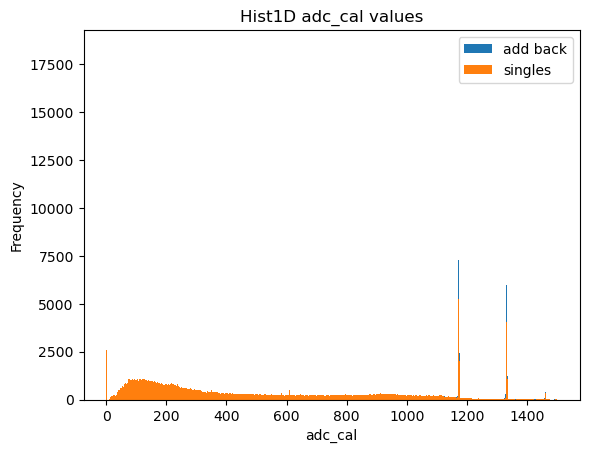

In [36]:
from hist.sparkHist1d import Hist1D
from matplotlib import pyplot as plt

Hist1D(df_addBack, "ab_energy", 1500, [0,1500], label="add back")
Hist1D(df, "adc_cal", 1500, [0,1500], label="singles")
plt.legend()
plt.show()

Add backによってピークのカウントが増えているのが分かる。
## γ-γ相関

